# Deep Learning with PyTorch : Build a Generative Adversarial Network

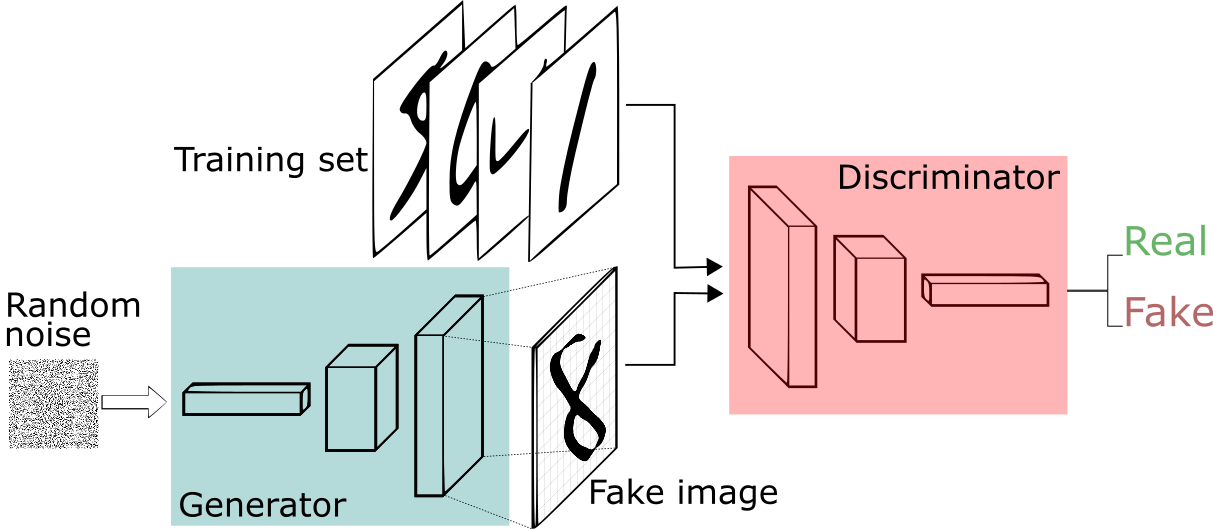

In [ ]:
#In case if torch summary is not installed

!pip install torchsummary


In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch import nn
from torchsummary import summary

### Load MNIST Dataset

The length of trainset is: 60000
torch.Size([1, 28, 28]) 5


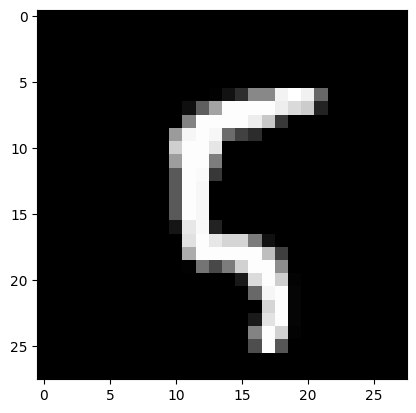

In [56]:
train_augs = T.Compose(
    [
        T.RandomRotation((-20, 20)),
        T.ToTensor(),  # (h,w,c) -> (c,h,w), range [0, 1]
        T.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ]
)
trainset = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augs)
print("The length of trainset is:", len(trainset))

image, label = trainset[100]
print(image.shape, label)
plt.imshow(image.squeeze(), cmap='gray')
plt.show()

### Configurations

In [57]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 512
noice_dim = 64  # noise vector dimension to pass into generator

# optimizer params
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999  # FIXED: Changed from 0.9 to 0.999 (standard for GANs)

# training variables
EPOCHS = 500

# Load Dataset Into Batches

Length of Trainloader = 118
shapes of images and labels: torch.Size([512, 1, 28, 28]) torch.Size([512])


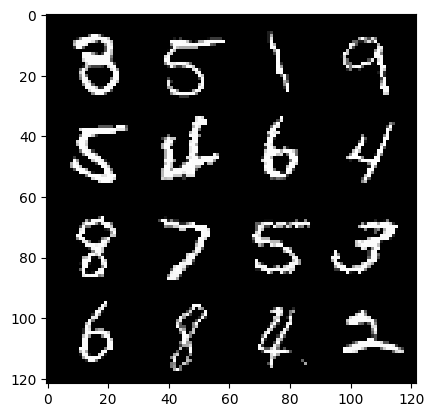

In [58]:
def show_tensor_images(tensor_img, num_images=16, size=(1, 28, 28)):
    """
    function is used to plot some of images from the batch
    """
    unflat_img = tensor_img[:num_images].detach().cpu()
    unflat_img = unflat_img * 0.5 + 0.5    # <-- DENORMALIZE back to [0,1]

    img_grid = make_grid(unflat_img, nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

    return

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
print("Length of Trainloader =", len(trainloader))

# loading 1st batch and it's shape
dataiter = iter(trainloader)
images, labels = next(dataiter)
print("shapes of images and labels:", images.shape, labels.shape)

show_tensor_images(images)

## Create Discriminator Network

> sample Discriminator structure

```css
Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)
```


In [59]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.block_1 = get_disc_block(1, 16, (3, 3), 2)
        self.block_2 = get_disc_block(16, 32, (5, 5), 2)
        self.block_3 = get_disc_block(32, 64, (5, 5), 2)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=64, out_features=1)

    def forward(self, images):
        x1 = self.block_1(images)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.flatten(x3)
        x5 = self.linear(x4)
        return x5

D = Discriminator()
D.to(device)
summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

## Create Generator Network

### sample Generator Structure

```css

Network : Generator

z_dim = 64  # noice_dim
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

```

In [60]:

def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
    if final_block == True:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh()
        )

    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class Generator(nn.Module):
    def __init__(self, noice_dim):
        super(Generator, self).__init__()

        self.noice_dim = noice_dim
        self.block_1 = get_gen_block(noice_dim, 256, (3, 3), 2)
        self.block_2 = get_gen_block(256, 128, (4, 4), 1)
        self.block_3 = get_gen_block(128, 64, (3, 3), 2)
        self.block_4 = get_gen_block(64, 1, (4, 4), 2, final_block=True)

    def forward(self, random_noice_vec):
        # (bs, noice_dim) -> (bs, noice, 1, 1)
        x = random_noice_vec.view(-1, self.noice_dim, 1, 1)

        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.block_4(x3)

        return x4

G = Generator(noice_dim)
G.to(device)
summary(G, input_size=(1, noice_dim))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [61]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

D = D.apply(weights_init)
G = G.apply(weights_init)

### Create Loss Function and Load Optimizer

In [62]:
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zeros_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2))

### Training Loop

Train 1/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 1 | D loss: 0.68783 | G loss: 0.70163


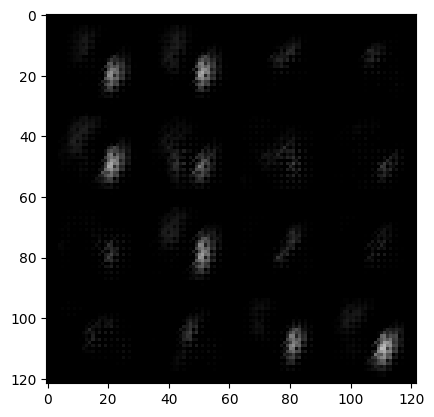

Train 2/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 2 | D loss: 0.67397 | G loss: 0.70707


Train 3/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 3 | D loss: 0.65899 | G loss: 0.71935


Train 4/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 4 | D loss: 0.65462 | G loss: 0.72339


Train 5/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 5 | D loss: 0.65768 | G loss: 0.72062


Train 6/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 6 | D loss: 0.66836 | G loss: 0.71752


Train 7/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 7 | D loss: 0.67571 | G loss: 0.71183


Train 8/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 8 | D loss: 0.68168 | G loss: 0.70700


Train 9/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 9 | D loss: 0.68297 | G loss: 0.70780


Train 10/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 10 | D loss: 0.68252 | G loss: 0.70803


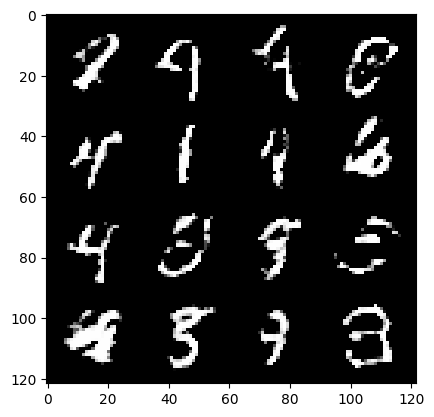

Train 11/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 11 | D loss: 0.68168 | G loss: 0.71022


Train 12/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 12 | D loss: 0.68093 | G loss: 0.71097


Train 13/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 13 | D loss: 0.67958 | G loss: 0.71374


Train 14/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 14 | D loss: 0.67744 | G loss: 0.71688


Train 15/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 15 | D loss: 0.67335 | G loss: 0.72437


Train 16/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 16 | D loss: 0.66770 | G loss: 0.73188


Train 17/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 17 | D loss: 0.66244 | G loss: 0.73995


Train 18/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 18 | D loss: 0.65845 | G loss: 0.74477


Train 19/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 19 | D loss: 0.65521 | G loss: 0.75068


Train 20/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 20 | D loss: 0.65184 | G loss: 0.75528


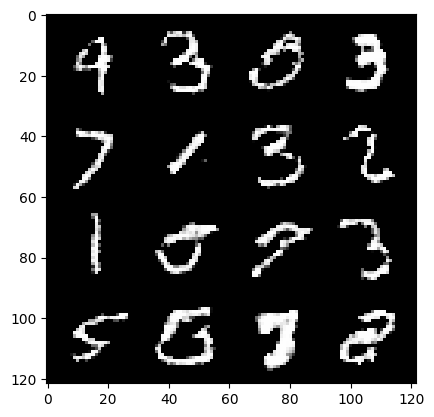

Train 21/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 21 | D loss: 0.64923 | G loss: 0.76050


Train 22/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 22 | D loss: 0.64591 | G loss: 0.76540


Train 23/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 23 | D loss: 0.64351 | G loss: 0.76746


Train 24/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 24 | D loss: 0.63927 | G loss: 0.77776


Train 25/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 25 | D loss: 0.63515 | G loss: 0.78222


Train 26/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 26 | D loss: 0.63395 | G loss: 0.78990


Train 27/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 27 | D loss: 0.62973 | G loss: 0.79959


Train 28/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 28 | D loss: 0.62596 | G loss: 0.80395


Train 29/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 29 | D loss: 0.62443 | G loss: 0.80983


Train 30/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 30 | D loss: 0.61928 | G loss: 0.81793


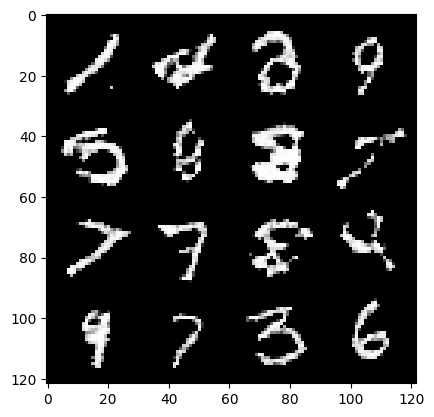

Train 31/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 31 | D loss: 0.61769 | G loss: 0.82292


Train 32/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 32 | D loss: 0.61691 | G loss: 0.82829


Train 33/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 33 | D loss: 0.61359 | G loss: 0.83334


Train 34/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 34 | D loss: 0.61169 | G loss: 0.84065


Train 35/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 35 | D loss: 0.60776 | G loss: 0.84781


Train 36/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 36 | D loss: 0.60527 | G loss: 0.85569


Train 37/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 37 | D loss: 0.60340 | G loss: 0.86035


Train 38/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 38 | D loss: 0.60064 | G loss: 0.86554


Train 39/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 39 | D loss: 0.59704 | G loss: 0.87161


Train 40/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 40 | D loss: 0.59777 | G loss: 0.87511


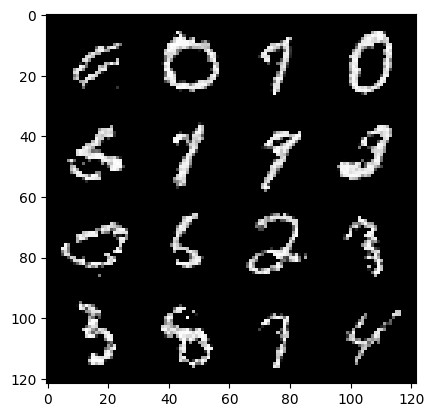

Train 41/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 41 | D loss: 0.59610 | G loss: 0.88203


Train 42/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 42 | D loss: 0.59514 | G loss: 0.88222


Train 43/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 43 | D loss: 0.59200 | G loss: 0.88735


Train 44/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 44 | D loss: 0.59057 | G loss: 0.89556


Train 45/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 45 | D loss: 0.59018 | G loss: 0.89831


Train 46/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 46 | D loss: 0.58888 | G loss: 0.90722


Train 47/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 47 | D loss: 0.58827 | G loss: 0.90970


Train 48/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 48 | D loss: 0.58286 | G loss: 0.91337


Train 49/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 49 | D loss: 0.58239 | G loss: 0.91718


Train 50/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 50 | D loss: 0.58244 | G loss: 0.93090


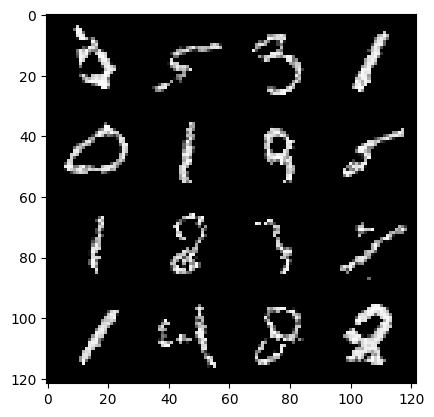

Train 51/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 51 | D loss: 0.57967 | G loss: 0.93442


Train 52/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 52 | D loss: 0.58219 | G loss: 0.93072


Train 53/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 53 | D loss: 0.57710 | G loss: 0.93965


Train 54/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 54 | D loss: 0.57715 | G loss: 0.94073


Train 55/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 55 | D loss: 0.57598 | G loss: 0.94419


Train 56/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 56 | D loss: 0.57274 | G loss: 0.95366


Train 57/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 57 | D loss: 0.57477 | G loss: 0.95290


Train 58/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 58 | D loss: 0.57134 | G loss: 0.95599


Train 59/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 59 | D loss: 0.57619 | G loss: 0.96205


Train 60/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 60 | D loss: 0.57231 | G loss: 0.95940


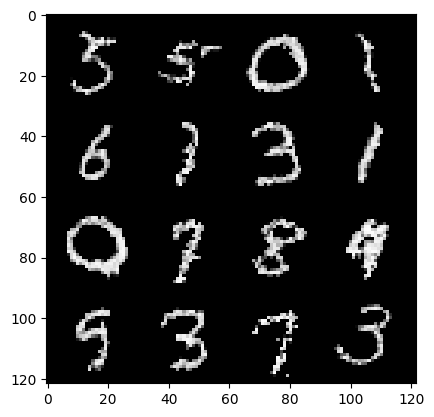

Train 61/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 61 | D loss: 0.57453 | G loss: 0.96885


Train 62/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 62 | D loss: 0.57211 | G loss: 0.96457


Train 63/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 63 | D loss: 0.57004 | G loss: 0.96816


Train 64/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 64 | D loss: 0.56876 | G loss: 0.97481


Train 65/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 65 | D loss: 0.56940 | G loss: 0.97761


Train 66/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 66 | D loss: 0.56956 | G loss: 0.97648


Train 67/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 67 | D loss: 0.57020 | G loss: 0.97932


Train 68/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 68 | D loss: 0.56745 | G loss: 0.98359


Train 69/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 69 | D loss: 0.56894 | G loss: 0.98053


Train 70/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 70 | D loss: 0.56953 | G loss: 0.97878


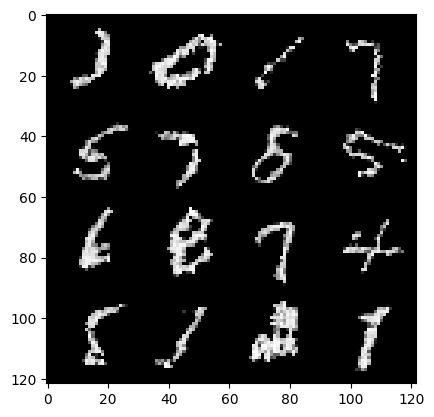

Train 71/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 71 | D loss: 0.57350 | G loss: 0.98667


Train 72/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 72 | D loss: 0.57063 | G loss: 0.98587


Train 73/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 73 | D loss: 0.56904 | G loss: 0.98332


Train 74/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 74 | D loss: 0.56895 | G loss: 0.98736


Train 75/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 75 | D loss: 0.57028 | G loss: 0.98683


Train 76/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 76 | D loss: 0.57118 | G loss: 0.99421


Train 77/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 77 | D loss: 0.57558 | G loss: 0.98378


Train 78/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 78 | D loss: 0.57463 | G loss: 0.99513


Train 79/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 79 | D loss: 0.57153 | G loss: 0.98136


Train 80/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 80 | D loss: 0.57585 | G loss: 0.99043


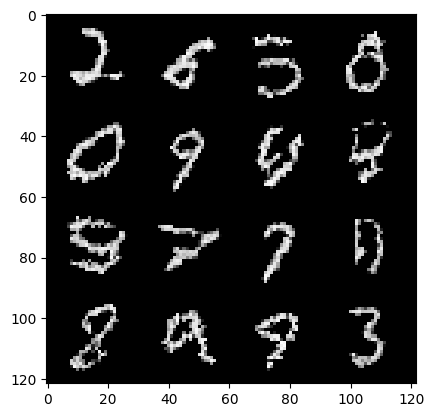

Train 81/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 81 | D loss: 0.56998 | G loss: 0.99241


Train 82/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 82 | D loss: 0.57131 | G loss: 0.99615


Train 83/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 83 | D loss: 0.57116 | G loss: 0.99605


Train 84/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 84 | D loss: 0.57121 | G loss: 0.99854


Train 85/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 85 | D loss: 0.57139 | G loss: 0.99150


Train 86/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 86 | D loss: 0.57355 | G loss: 1.00018


Train 87/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 87 | D loss: 0.57226 | G loss: 0.99400


Train 88/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 88 | D loss: 0.57574 | G loss: 0.99701


Train 89/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 89 | D loss: 0.56755 | G loss: 0.99505


Train 90/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 90 | D loss: 0.57378 | G loss: 1.00281


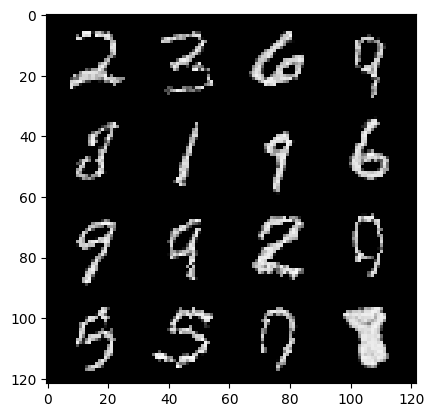

Train 91/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 91 | D loss: 0.57230 | G loss: 1.00536


Train 92/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 92 | D loss: 0.57135 | G loss: 1.00238


Train 93/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 93 | D loss: 0.57344 | G loss: 1.00261


Train 94/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 94 | D loss: 0.57257 | G loss: 0.99986


Train 95/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 95 | D loss: 0.57222 | G loss: 0.99951


Train 96/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 96 | D loss: 0.57620 | G loss: 1.00614


Train 97/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 97 | D loss: 0.57272 | G loss: 1.00189


Train 98/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 98 | D loss: 0.57369 | G loss: 1.01252


Train 99/500:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch: 99 | D loss: 0.57459 | G loss: 1.00561


Train 100/500:   0%|          | 0/118 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [63]:

for epoch in range(EPOCHS):
    total_d_loss = 0.0
    total_g_loss = 0.0
    pbar = tqdm(trainloader, desc=f"Train {epoch+1}/{EPOCHS}")

    for real_img, _ in pbar:
        real_img = real_img.to(device)
        current_batch_size = real_img.size(0)  # Handle last batch

        # ============================================
        # Train Discriminator
        # ============================================
        D_opt.zero_grad()

        # Train on real images
        D_pred_real = D(real_img)
        D_real_loss = real_loss(D_pred_real)

        # Train on fake images
        noice = torch.randn(current_batch_size, noice_dim, device=device)
        fake_img = G(noice)
        # FIXED: Detach fake images to prevent gradients flowing to Generator
        D_pred_fake = D(fake_img.detach())
        D_fake_loss = fake_loss(D_pred_fake)

        # Combine losses and update
        D_loss = (D_fake_loss + D_real_loss) / 2
        D_loss.backward()
        D_opt.step()

        total_d_loss += D_loss.item()

        # ============================================
        # Train Generator
        # ============================================
        G_opt.zero_grad()

        # FIXED: Generate fresh noise for generator training
        noice = torch.randn(current_batch_size, noice_dim, device=device)
        fake_img = G(noice)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)  # Generator wants discriminator to think fakes are real

        G_loss.backward()
        G_opt.step()

        total_g_loss += G_loss.item()

        # Update progress bar
        pbar.set_postfix({
            'D_loss': f'{D_loss.item():.4f}',
            'G_loss': f'{G_loss.item():.4f}'
        })

    avg_d_loss = total_d_loss / len(trainloader)
    avg_g_loss = total_g_loss / len(trainloader)

    # FIXED: Changed 'i' to 'epoch'
    print(f"Epoch: {epoch+1} | D loss: {avg_d_loss:.5f} | G loss: {avg_g_loss:.5f}")

    # Show generated images every epoch
    if (epoch + 1) % 10 == 0 or epoch == 0:
        show_tensor_images(fake_img)


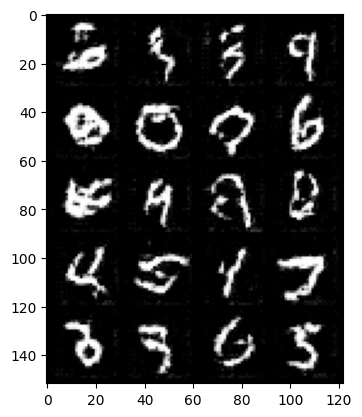

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images
print("\nGenerating final images...")
noise = torch.randn(batch_size, noice_dim, device=device)
generated_image = G(noise)
show_tensor_images(generated_image)